In [1]:
import os
import sys
home_dir = "../../"
module_path = os.path.abspath(os.path.join(home_dir))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd

(7179, 30)
Index(['mut_id', 'md5', 'pmd_id', 'nr', 'prot_acc_version', 'snp_id',
       'mut_real', 'wt', 'mut', 'prot_pos', 'chrom', 'chrom_pos', 'ref_allele',
       'alt_allele', 'function', 'source', 'crossref', 'function_summarized',
       'class', 'SIFT_score', 'Polyphen2_HVAR_score', 'MetaRNN_score',
       'REVEL_score', 'MVP_score', 'CADD_raw_score',
       'integrated_fitCons_score', 'phyloP17way_primate_score',
       'phastCons17way_primate_score', 'bStatistic_score', 'pred'],
      dtype='object')


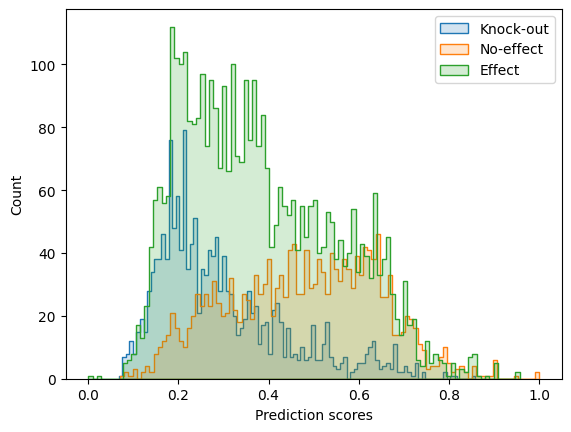

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_distribution(result_df, n_samples=None):
    df = result_df.copy(deep=True)
    plt.cla()

    effect = df[df["class"]=="Effect"]
    knock_out = df[df["class"]=="Knock-out"]
    no_effect = df[df["class"]=="No-effect"]

    if n_samples is not None:
        effect = effect.sample(n=n_samples)
        knock_out = knock_out.sample(n=n_samples)
        no_effect = no_effect.sample(n=n_samples)

    # print(effect.shape, knock_out.shape, no_effect.shape)
    bins = 100 # 20, 100, 500
    
    sns.histplot(knock_out["pred"], bins=bins, label=f"Knock-out", element="step", alpha=.2)
    sns.histplot(no_effect["pred"], bins=bins, label=f"No-effect", element="step", alpha=.2)
    sns.histplot(effect["pred"], bins=bins, label=f"Effect", element="step", alpha=.2)
    # sns.histplot(result_df, x="pred", y="class", element="step", hue="class", bins=bins, alpha=0.2)
    
    plt.legend()
    plt.xlabel("Prediction scores")
    plt.ylabel("Count")
    plt.show()

result_df = pd.read_csv(home_dir+f"models/vespa_marquet/outputs/vespa/pmd/preds_vespa_masked.tsv", sep="\t")
# result_df = result_df[result_df["crossref"].apply(lambda x: True if "HUMAN" in x else False)] # number of human entries: 16996
model_pred_col = "pred"
result_df["pred"]=(result_df[model_pred_col]-result_df[model_pred_col].min())/(result_df[model_pred_col].max()-result_df[model_pred_col].min()) # scaling prediction scores between [0, 1]
# result_df["pred"]=result_df[model_pred_col]
print(result_df.shape)
print(result_df.columns)
result_df["class"].value_counts()
plot_distribution(result_df, n_samples=None)

In [15]:
# does masking change the logits: yes.
# loading logits from from same seq but masked in different position.
import utils.pickle_utils as pickle_utils
logits_1 = pickle_utils.load_pickle(home_dir+f"models/vespa_marquet/outputs/vespa/lm_outputs/A000006_2_271.pkl") 
logits_2 = pickle_utils.load_pickle(home_dir+f"models/vespa_marquet/outputs/vespa/lm_outputs/A000006_2_62.pkl") 

# now see, logits in masked position are different, 
# print(logits_1[270])
# print(logits_2[270])
# but non-masked position are same.
print(logits_1[1])
print(logits_2[1])

[-33.156746  -63.77427   -78.99706   -20.993095  -21.187574  -21.610321
  -2.5832345 -22.559183  -22.489191  -22.046467  -22.128855  -21.394297
 -20.335943  -22.568993  -24.529009  -21.514837  -23.488838  -25.2221
 -23.25599   -21.255157  -22.606035  -23.757666  -21.957117  -28.786419
 -80.533875  -79.5117    -79.73186   -80.20427   -79.8126    -79.29852
 -80.29359   -79.33893   -79.16435   -80.27566   -80.21593   -80.27733
 -79.87892   -78.20445   -79.39288   -80.375496  -79.25843   -79.64636
 -80.277725  -79.83879   -78.505104  -79.48121   -79.53682   -79.67142
 -79.08185   -79.77395   -80.11462   -79.755035  -79.69339   -78.76579
 -79.97042   -80.023834  -78.62574   -78.97765   -80.01468   -78.716
 -79.67464   -80.44788   -78.887054  -79.44233   -78.43563   -79.384964
 -79.002785  -79.55917   -79.396255  -80.13838   -79.91325   -79.51456
 -79.71684   -79.05998   -80.04007   -79.30025   -79.136284  -79.45889
 -79.55593   -80.020584  -79.199615  -79.79599   -79.62452   -80.30044
 -79.

In [12]:

logits.shape
logits[0]

array([-29.579014 , -53.59983  , -79.53206  , -22.216896 , -21.187664 ,
       -24.78938  , -23.088902 , -22.943327 , -26.095236 , -24.95914  ,
       -26.029783 , -22.326487 , -22.535503 , -23.801205 , -24.82621  ,
       -22.569172 , -21.9707   , -25.28495  , -23.068161 ,  -2.6807983,
       -26.029684 , -24.256947 , -24.971144 , -29.97383  , -80.36075  ,
       -80.02669  , -79.31144  , -79.422165 , -78.548004 , -79.658325 ,
       -79.04041  , -80.0919   , -79.1655   , -80.9721   , -79.87311  ,
       -80.55377  , -79.31018  , -78.767525 , -79.80408  , -79.88929  ,
       -78.02374  , -80.07918  , -80.06229  , -80.088974 , -77.911354 ,
       -79.47255  , -78.986496 , -77.76311  , -79.66431  , -79.73583  ,
       -79.33857  , -79.46689  , -78.93982  , -78.16316  , -79.98491  ,
       -79.58761  , -77.09551  , -78.21783  , -80.1122   , -78.81305  ,
       -79.375    , -79.08338  , -79.604095 , -79.120735 , -77.63766  ,
       -78.44606  , -77.4949   , -78.3591   , -79.02359  , -80.6

In [2]:
from vespa.predict.logodds import *
import vespa.predict.utils as vespa_utils

/projects/ashehu/akabir4/venvs/hopper_vespa_marquet_from_source/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda:0


In [3]:
cache_dir=home_dir+"models/vespa_marquet/cache"
t5_condProbas = T5_condProbas(cache_dir=cache_dir)
model, tokenizer = t5_condProbas.prott5.get_model(1) #1=LOGODDS

In [11]:
seq = "AMVNSTHR" # eos token added
seq = " ".join(list(seq))
model.to("cpu")
input_ids = tokenizer(seq, return_tensors="pt").input_ids.to("cpu")
print(input_ids)
with torch.no_grad():  # only logits is useful for us
    logits = model(input_ids, labels=input_ids).logits
    logits = logits[0].detach().numpy() 

print(logits.shape)

tensor([[ 3, 19,  6, 17,  7, 11, 20,  8,  1]])
(9, 128)


In [14]:
tokenizer.convert_tokens_to_ids("▁V")

6

In [9]:
from pathlib import Path
seq_dict = vespa_utils.parse_fasta_input(Path(home_dir+"models/aa_common/datasets_pmd_analysis/pmd_sequences.fasta")) # this replaces the unknown amino acids UZO, not B
print(len(seq_dict))
protid_seq_dict_list = [(prot_id, seq) for prot_id, seq in  seq_dict.items()]
protid, seq = protid_seq_dict_list[0]
seq

11714


'MVNSTHRGMHTSLHLWNRSSYRLHSNASESLGKGYSDGGCYEQLFVSPEVFVTLGVISLLENILVIVAIAKNKNLHSPMYFFICSLAVADMLVSVSNGSETIVITLLNSTDTDAQSFTVNIDNVIDSVICSSLLASICSLLSIAVDRYFTIFYALQYHNIMTVKRVGIIISCIWAACTVSGILFIIYSDSSAVIICLITMFFTMLALMASLYVHMFLMARLHIKRIAVLPGTGAIRQGANMKGAITLTILIGVFVVCWAPFFLHLIFYISCPQNPYCVCFMSHFNLYLILIMCNSIIDPLIYALRSQELRKTFKEIICCYPLGGLCDLSSRY'

In [17]:
a_prot_seq = protid_seq_dict_list[0]
csv_dir = home_dir+"models/vespa_marquet/outputs/vespa/lm_outputs"
mutation_gen = vespa_utils.MutationGenerator(sequence_dict=a_prot_seq)
proba_dict = t5_condProbas.get_proba_dict(a_prot_seq, mutation_gen)
dmiss_data = t5_condProbas.get_log_odds(proba_dict)
T5_condProbas.write_csv_dir(dmiss_data, csv_dir, mutation_gen)

OutOfMemoryError: CUDA out of memory. Tried to allocate 16.00 MiB (GPU 0; 14.76 GiB total capacity; 9.02 GiB already allocated; 17.75 MiB free; 9.02 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [17]:
import re
seq = "CUDA"
re.sub(r"[UZOB]", "X", seq)

'CXDA'

In [ ]:
import vespa.predict.utils as vespa_utils
from pathlib import Path
seq_dict = vespa_utils.parse_fasta_input(Path(home_dir+"models/aa_common/datasets_pmd_analysis/pmd_sequences.fasta"))
print(len(seq_dict))
# protid_seq_dict_list = [{prot_id: seq} for prot_id, seq in  seq_dict.items()]
protid_seq_dict_list = [(prot_id, seq) for prot_id, seq in  seq_dict.items()]
protid, seq = protid_seq_dict_list[0]
print(protid, seq)